#**Udacity: Introduction to TensorFlow for Deep Learning**

## Lesson 5

In this colab notebook, i **implemented a convolutional neural network that can classify images of dogs and cats**.

**Concepts introduced**
1. Data Augmentation.
2. Working with color images and how it affects the convolution and pooling layer operation.
3. Solutions to overfitting.

## **Import the Dependencies**

In [ ]:
# import core python libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.5.0


## **Get the data**

In this lesson, the ImageDataGenerator is used to apply data augmentations to our training set. Looking at the [.flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory), method in the ImageDataGenerator class would read data from the disk.

So as opposed to working with files within the workspace of the notebook, it would be better to have the files within the local disk, where the colab notebook is hosted. Hence we use the [utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function



For this lesson, the **cats_and_dogs_filtered** dataset would be used to train a cnn model.   
The cats_and_dogs_filtered dataset contains
- Colored images of cats and dogs at different sizes.
- 2000 Training Images (1000 Dog, 1000 cats)
- 1000 Validation Images
- Labels: 1 - Dog, 0 - Cat


In [ ]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

print(zip_dir)

/root/.keras/datasets/cats_and_dogs_filtered.zip


In [ ]:
# list the directories
zip_dir_base = os.path.dirname(zip_dir)
print(zip_dir_base)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


In [ ]:
# define the directories for some of our files
# zip_dir = /root/.keras/datasets/

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# training dataset
train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('Total number of training examples: {}, cats data: {}, dogs data: {}'.format(num_cats_tr+num_dogs_tr, num_cats_tr, num_dogs_tr))

# validation dataset
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('Total number of training examples: {}, cats data: {}, dogs data: {}'.format(num_cats_val+num_dogs_val, num_cats_val, num_dogs_val))



Total number of training examples: 2000, cats data: 1000, dogs data: 1000
Total number of training examples: 1000, cats data: 500, dogs data: 500


## **Data Preprocessing and Exploration (Firstpass without data augmentation)**

The data needs to be preprocessed before it can be feed straight to the neural network.

Preprocessing steps
1. Read Images from disk
2. Decode contents of images and convert into proper grid format as per RGB content
3. Convert into floating point tensors


4. Rescale tensor from values between 0 - 255 to values between 0 and 1.
5. Resize the images into a single resolution.

In [ ]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [ ]:
# Preprocess the data
# Create an instance of the ImageDataGenerator class

# Set the ImageDataGenerator class to rescale the images to 1/255
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# use the flow_from_directory method within the class
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode = 'binary')


Found 2000 images belonging to 2 classes.


In [ ]:
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                     directory=validation_dir,
                                                                     shuffle=False,
                                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


View some of the training data

In [ ]:
# get a single batch from the training dataset.
# batch contains images and label

sample_training_images, _ = next(train_data_gen)

In [ ]:
print(type(sample_training_images))
print(len(sample_training_images))

<class 'numpy.ndarray'>
100


In [ ]:
print(sample_training_images.shape)

(100, 150, 150, 3)


In [ ]:
def plotImage(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

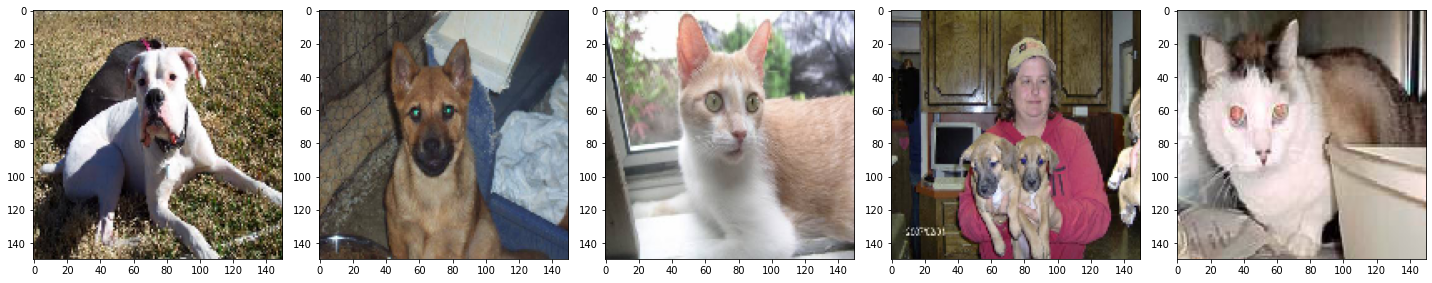

In [ ]:
plotImage(sample_training_images[:5])

## **Build and Train the model on the Data without Augmentation**


*Side note*
Might be best to create a function to build the model, train and plot the training history

In [ ]:
def build_and_compile_model():
  '''
  Function returns a cnn model with fixed size.
  '''
  model = tf.keras.models.Sequential()
  pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))


  # define feature extraction layers
  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
  model.add(pooling_layer)
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
  model.add(pooling_layer)
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(pooling_layer)
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(pooling_layer)

  # define classification layer
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=512, activation='relu'))
  model.add(tf.keras.layers.Dense(units=2)) # covered by SparseCategoricalCrossentropy loss function

  # compile the model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
Cnn_model_trained_without_data_augmentation = build_and_compile_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

looking at the model summary, it's a bit worrying the wau in which the max_pooling2D layers are presented.

:tired_face:

In [ ]:
# rebuild same model and look at how it's summary is presented
model = tf.keras.models.Sequential()
pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))


# define feature extraction layers
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# define classification layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=2))

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

So both model have their layers ordered differently. hmm

In [ ]:
# Train the models

def train_model(model):
  """
  Function trains a model and returns it along with it's history 
  """
  EPOCHS = 100
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
  history = model.fit(
      train_data_gen,
      steps_per_epoch=int(np.ceil(2000 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=validation_data_gen,
      validation_steps=int(np.ceil(1000 / float(BATCH_SIZE))),
      callbacks = [early_stopping]
  )
  return (model, history)


In [ ]:
cnn_model_with_dodgy_layers = train_model(Cnn_model_trained_without_data_augmentation)

Epoch 1/100
20/20 [==============================] - 41s 423ms/step - loss: 0.7424 - accuracy: 0.5040 - val_loss: 0.6898 - val_accuracy: 0.5010
Epoch 2/100
20/20 [==============================] - 8s 402ms/step - loss: 0.6921 - accuracy: 0.5110 - val_loss: 0.6911 - val_accuracy: 0.5290
Epoch 3/100
20/20 [==============================] - 8s 403ms/step - loss: 0.6917 - accuracy: 0.5160 - val_loss: 0.6782 - val_accuracy: 0.5970
Epoch 4/100
20/20 [==============================] - 8s 399ms/step - loss: 0.6832 - accuracy: 0.5585 - val_loss: 0.6885 - val_accuracy: 0.5320
Epoch 5/100
20/20 [==============================] - 8s 397ms/step - loss: 0.6662 - accuracy: 0.6030 - val_loss: 0.6737 - val_accuracy: 0.6260
Epoch 6/100
20/20 [==============================] - 8s 407ms/step - loss: 0.6273 - accuracy: 0.6255 - val_loss: 0.6189 - val_accuracy: 0.6540
Epoch 7/100
20/20 [==============================] - 8s 427ms/step - loss: 0.5950 - accuracy: 0.6845 - val_loss: 0.6093 - val_accuracy: 0.656

In [ ]:
normal_cnn_model = train_model(model)

Epoch 1/100
20/20 [==============================] - 9s 444ms/step - loss: 0.7085 - accuracy: 0.5105 - val_loss: 0.6928 - val_accuracy: 0.5320
Epoch 2/100
20/20 [==============================] - 8s 414ms/step - loss: 0.6918 - accuracy: 0.5225 - val_loss: 0.6908 - val_accuracy: 0.5010
Epoch 3/100
20/20 [==============================] - 8s 398ms/step - loss: 0.6892 - accuracy: 0.5380 - val_loss: 0.6837 - val_accuracy: 0.5170
Epoch 4/100
20/20 [==============================] - 8s 399ms/step - loss: 0.6720 - accuracy: 0.5975 - val_loss: 0.6455 - val_accuracy: 0.6310
Epoch 5/100
20/20 [==============================] - 8s 397ms/step - loss: 0.6126 - accuracy: 0.6845 - val_loss: 0.6232 - val_accuracy: 0.6530
Epoch 6/100
20/20 [==============================] - 8s 393ms/step - loss: 0.5728 - accuracy: 0.6995 - val_loss: 0.5661 - val_accuracy: 0.7070
Epoch 7/100
20/20 [==============================] - 8s 399ms/step - loss: 0.5215 - accuracy: 0.7405 - val_loss: 0.5977 - val_accuracy: 0.6930

So both model saved seemly identical structure performed differently during training on the same dataset

In [ ]:
def print_model_training_history(history, Epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(Epochs)

  plt.figure(figsize=(8,8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('./foo.png')
  plt.show()

In [ ]:
cnn_model1, cnn_model1_history = cnn_model_with_dodgy_layers
cnn_model2, cnn_model2_history = normal_cnn_model


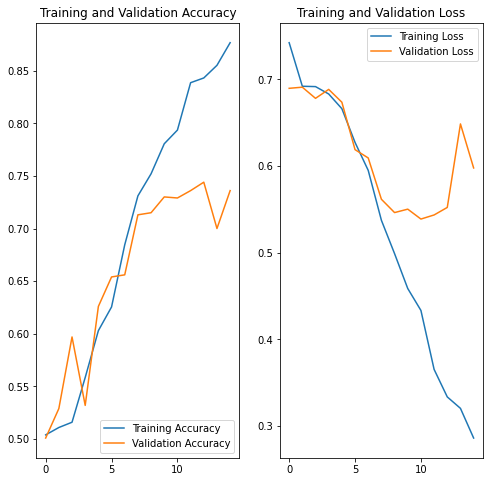

Model final accuracy: Training 0.88 and Validation 0.74
Model final Loss: Training 0.29 and Validation 0.60


In [ ]:
print_model_training_history(cnn_model1_history, len(cnn_model1_history.history['accuracy']))

# Print model final performance
print('Model final accuracy: Training {:.2f} and Validation {:.2f}'.format(cnn_model1_history.history['accuracy'][-1], cnn_model1_history.history['val_accuracy'][-1]))
print('Model final Loss: Training {:.2f} and Validation {:.2f}'.format(cnn_model1_history.history['loss'][-1], cnn_model1_history.history['val_loss'][-1]))

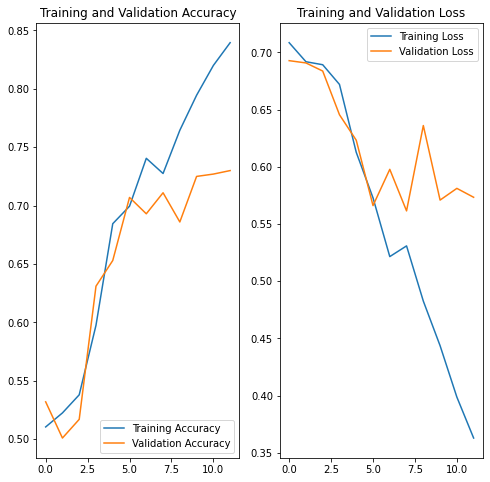

Model final accuracy: Training 0.84 and Validation 0.73
Model final Loss: Training 0.36 and Validation 0.57


In [ ]:
print_model_training_history(cnn_model2_history, len(cnn_model2_history.history['accuracy']))

# Print model final performance
print('Model final accuracy: Training {:.2f} and Validation {:.2f}'.format(cnn_model2_history.history['accuracy'][-1], cnn_model2_history.history['val_accuracy'][-1]))
print('Model final Loss: Training {:.2f} and Validation {:.2f}'.format(cnn_model2_history.history['loss'][-1], cnn_model2_history.history['val_loss'][-1]))

Okay so both models are the same and are not that different

## **Include Data Augmentation**

The ImageDataGenerator class would be used to apply random image augmentation to the data

In [ ]:
aug_train_image_data = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2)

# the same validation ImageDataGenerator would be used

aug_train_images = aug_train_image_data.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode = 'binary')

Found 2000 images belonging to 2 classes.


(100, 150, 150, 3)


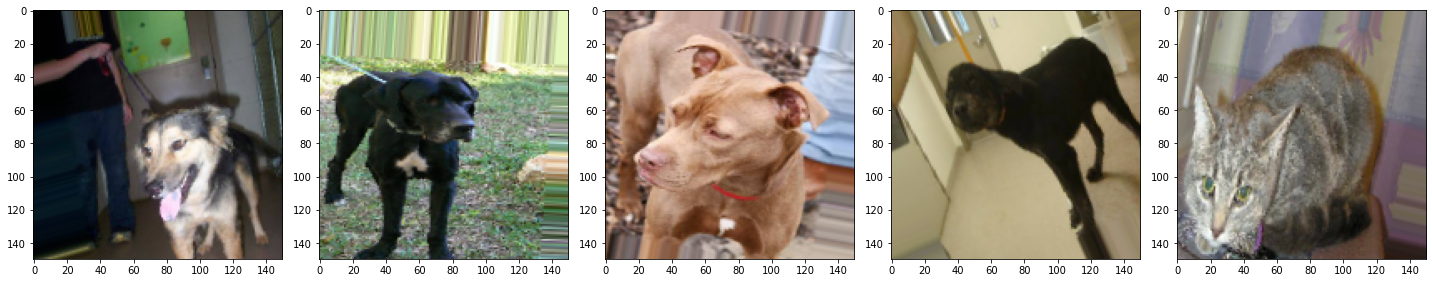

In [ ]:
augmented_train_data_single_batch, _ = next(aug_train_images)

print(augmented_train_data_single_batch.shape)

plotImage(augmented_train_data_single_batch[:5])

Something interesting to note.

The size of the batch remains, the same which i suppose makes sense. But what i expect is a much larger training set

In [ ]:
print(len(aug_train_images))

20


but we have the same 2000 training set. hmmmmm

In [ ]:
# define a new model (with a droput layer)
cnn_with_dropout = tf.keras.Sequential()

# Feature learning layers
cnn_with_dropout.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
cnn_with_dropout.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

cnn_with_dropout.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_with_dropout.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn_with_dropout.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_with_dropout.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

cnn_with_dropout.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn_with_dropout.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Classification layer
cnn_with_dropout.add(tf.keras.layers.Dropout(0.5))
cnn_with_dropout.add(tf.keras.layers.Flatten())
cnn_with_dropout.add(tf.keras.layers.Dense(units=512, activation='relu'))
cnn_with_dropout.add(tf.keras.layers.Dense(units=2, activation='softmax'))


# compile the model
cnn_with_dropout.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# model summary
cnn_with_dropout.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

## **Train the model on Data with Augmentation**

In [ ]:
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = cnn_with_dropout.fit(
    aug_train_images,
    steps_per_epoch=int(np.ceil(2000/ float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=validation_data_gen,
    validation_steps=int(np.ceil(1000 / float(BATCH_SIZE))),
    callbacks = [early_stopping]
)

Epoch 1/100
20/20 [==============================] - 17s 821ms/step - loss: 0.6893 - accuracy: 0.5295 - val_loss: 0.6588 - val_accuracy: 0.6140
Epoch 2/100
20/20 [==============================] - 16s 822ms/step - loss: 0.6657 - accuracy: 0.5640 - val_loss: 0.6408 - val_accuracy: 0.6060
Epoch 3/100
20/20 [==============================] - 17s 868ms/step - loss: 0.6502 - accuracy: 0.6120 - val_loss: 0.6209 - val_accuracy: 0.6520
Epoch 4/100
20/20 [==============================] - 16s 812ms/step - loss: 0.6426 - accuracy: 0.6315 - val_loss: 0.6073 - val_accuracy: 0.6810
Epoch 5/100
20/20 [==============================] - 16s 802ms/step - loss: 0.6029 - accuracy: 0.6690 - val_loss: 0.6148 - val_accuracy: 0.6790
Epoch 6/100
20/20 [==============================] - 16s 827ms/step - loss: 0.6117 - accuracy: 0.6655 - val_loss: 0.6449 - val_accuracy: 0.6100
Epoch 7/100
20/20 [==============================] - 17s 864ms/step - loss: 0.6154 - accuracy: 0.6620 - val_loss: 0.5885 - val_accuracy:

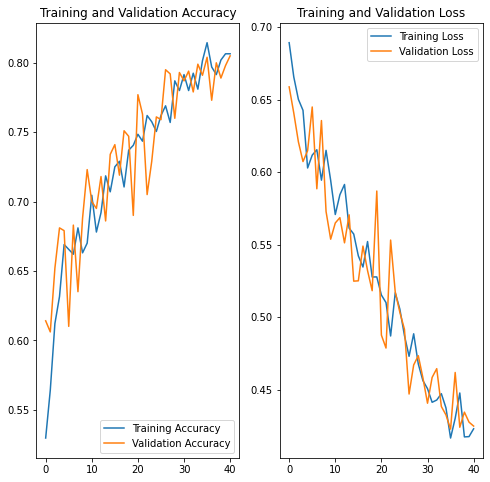

In [ ]:
print_model_training_history(history, len(history.history['loss']))

In [ ]:
print('Model performance on: ')
print('Model Accuracy: Training {:.2f} and Validation {:.2f}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
print('Model Loss: Training {:.2f} and Validation {:.2f}'.format(history.history['loss'][-1], history.history['val_loss'][-1]))

Model performance on: 
Model Accuracy: Training 0.81 and Validation 0.81
Model Loss: Training 0.42 and Validation 0.42


Okay i wasn't expecting that. It's performance on both set are the same.

## Evaluate the model on the test set

No test set to evaluate the model on.